# Shopping Apps, Rating for Google Play Store and Apple AppStore Users

## Introduction

Users download apps for various purposes. Given that there is a rise in the usage of online shopping due to the Covid-19 pandemic, improvement of shopping experience has become more important then before. With that in mind, what are the important features we have to look out for to improve a shopping app?

More specifically, the questions to be answered:

- How do the app ratings differ across different shopping apps?
- Is there any specific group of users we can look out for to improve the app?
- Are there any specific improvement we can work on to further improve user experience of the app?

To explore and answer the above questions, we will scrap reviews from Google Play Store and Apple AppStore and conduct analysis and modelling.

# Import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('pastel')
import plotly.graph_objects as go
from plotly.offline import iplot, init_notebook_mode
from ipywidgets import widgets

#setting cufflinks to link iplot() method to df
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)


from time import time

from PIL import Image
from wordcloud import WordCloud

from bs4 import BeautifulSoup
import re
import spacy
from spacymoji import Emoji
from nltk.corpus import stopwords, words
from nltk import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer as lemmatize
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer

import sys
from pprint import pprint

# Gensim
import gensim, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle

import pyLDAvis.gensim

# Import Data

In [2]:
df = pd.read_csv('../data/cleaned_reviews.csv')

In [3]:
df.head()

,rating,date,app,store,review,clean_content,adj,noun,verb,emoji,neg_score,neu_score,pos_score,compound_score
0,5,2020-09-16 20:26:28,shoppee,google,Orders mostly came early and products are good.,came early good,good,order product,come,NaN,0.0,0.707,0.293,0.4404
1,4,2020-09-16 20:13:46,shoppee,google,Good and convenient,good convenient,good convenient,NaN,NaN,NaN,0.0,0.408,0.592,0.4404
2,5,2020-09-16 20:13:05,shoppee,google,Gd...........,NaN,NaN,NaN,NaN,NaN,0.0,1.000,0.000,0.0000
3,4,2020-09-16 20:11:18,shoppee,google,My first purchase experience...Happy with purc...,purchase experience happy,first happy,purchase experience purchase,NaN,NaN,0.0,0.714,0.286,0.3400
4,5,2020-09-16 20:08:54,shoppee,google,A lot of items at a very good deal.,lot good deal,good,lot item deal,NaN,NaN,0.0,0.715,0.285,0.4927


# Removing null values

In [4]:
df= df[df['clean_content'].notna()]
df.reset_index(inplace = True, drop = True)

In [5]:
df.isna().sum()[df.isna().sum() != 0]

adj      14022
noun     21875
verb     31718
emoji    69477
dtype: int64

## Changing Date Data to datetime dtype

In [6]:
df['date'] = df['date'].astype('datetime64')

## Creating new columns for eda

### New time columns

In [7]:
df['month'] = df.date.dt.month
df['dayofweek'] = df.date.dt.dayofweek + 1 #adding 1 as the data starts from 0 for monday, this is to avoid confusion
df['hour'] = df.date.dt.hour
df['minute'] = df.date.dt.minute

### Length of text columns

In [8]:
df['text_len'] = df['review'].str.len()
df['word_count'] = df['review'].str.split().str.len()

# EDA

## Distribution of App, Rating, Store, Month and DayofWeek

In [9]:
def plot_countplots(df, features):
    nrows = int(np.ceil(len(features)/2))
    fig, ax = plt.subplots(nrows, 2, figsize=(18,6*nrows))
    ax = ax.ravel()
    for i in range(len(features)):
        ax[i].set_title(f'Count of {features[i]} across Shopping reviews', fontdict = {'fontsize': 10})
        sns.countplot(x = features[i], data = df, ax = ax[i]);

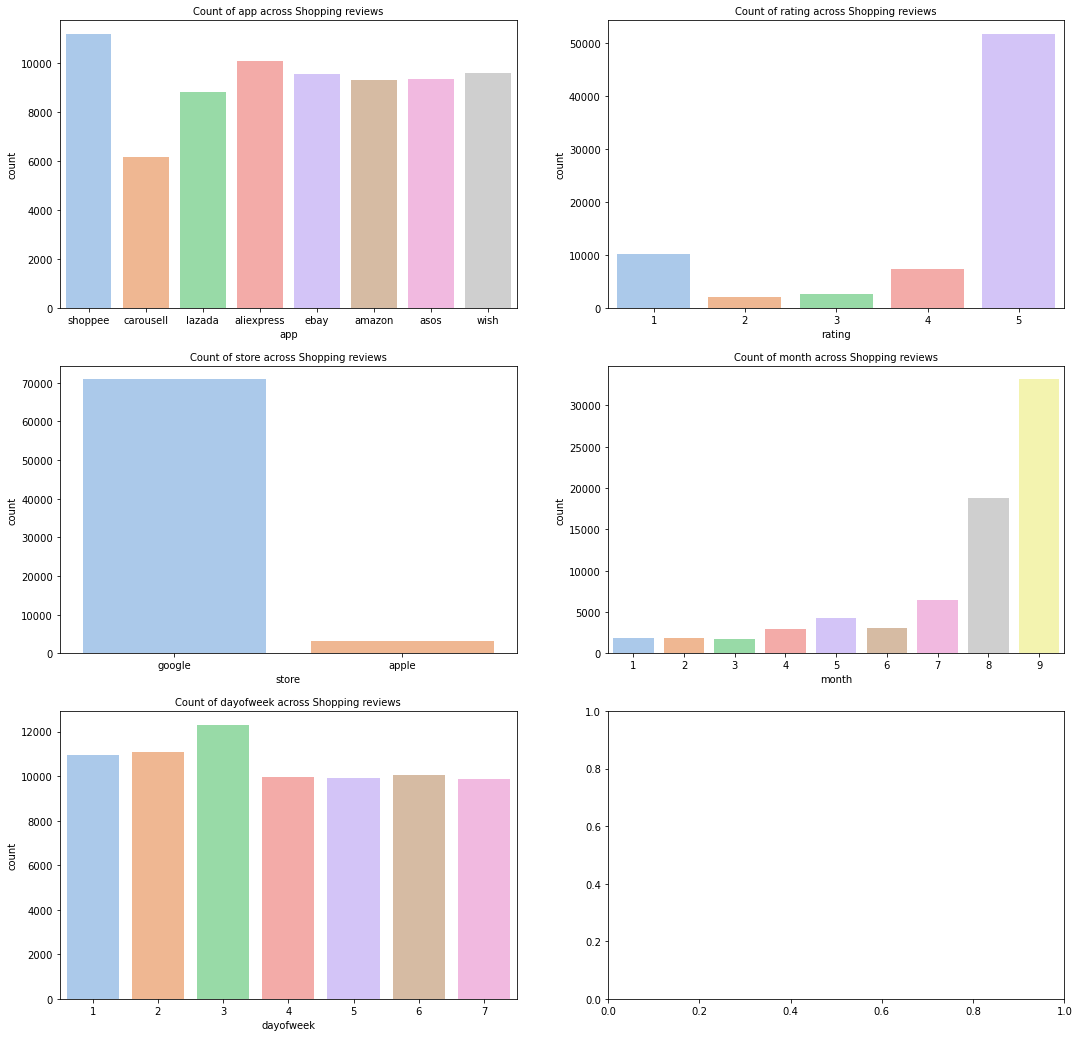

In [10]:
plot_countplots(df, ['app', 'rating', 'store', 'month', 'dayofweek'])

## Distribution by Hour, DayofWeek

In [12]:
def plot_countplots_time(df, date_features, scoring):
    nrows = int(np.ceil(len(date_features)))
    fig,ax = plt.subplots(nrows,1, figsize = (15, 6*nrows))
    
    for i in range(len(date_features)):
        ax[i].set_title(f'Count of {date_features[i]} across Shopping reviews {scoring}', fontdict = {'fontsize': 20})
        g = sns.countplot(x = date_features[i] , data = df, ax=ax[i])
        g2 = g.twinx()
        
        g2 = sns.pointplot(x = date_features[i],
                           y = scoring, 
                           data = df ,
                           ax=g2, color = 'black')
        
        plt.legend(labels = [f'{scoring} mean'])
    plt.show()

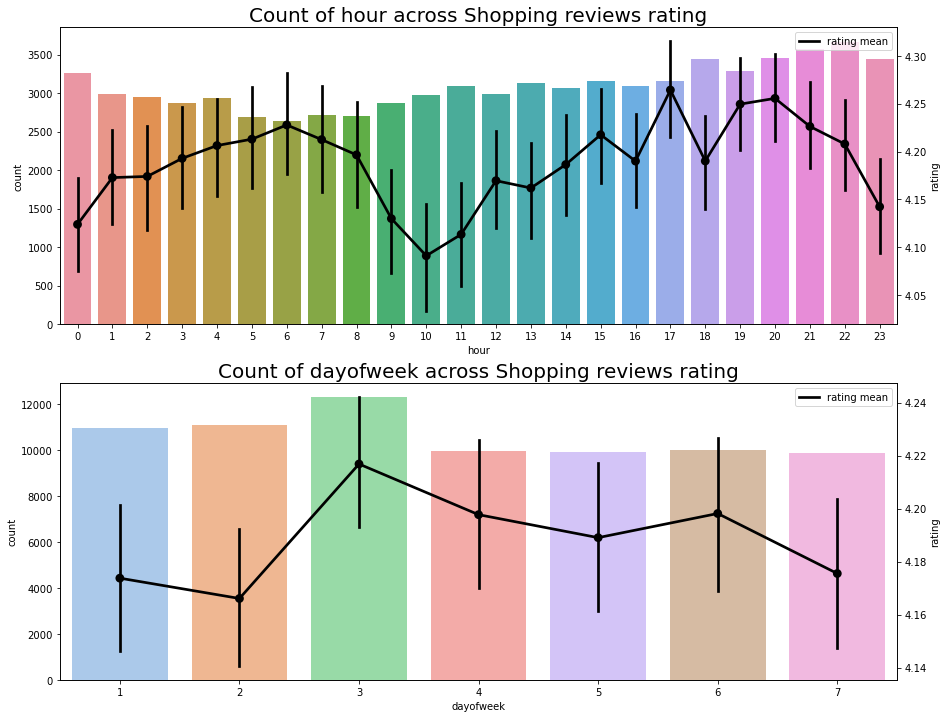

In [13]:
plot_countplots_time(df, ['hour', 'dayofweek'], 'rating')

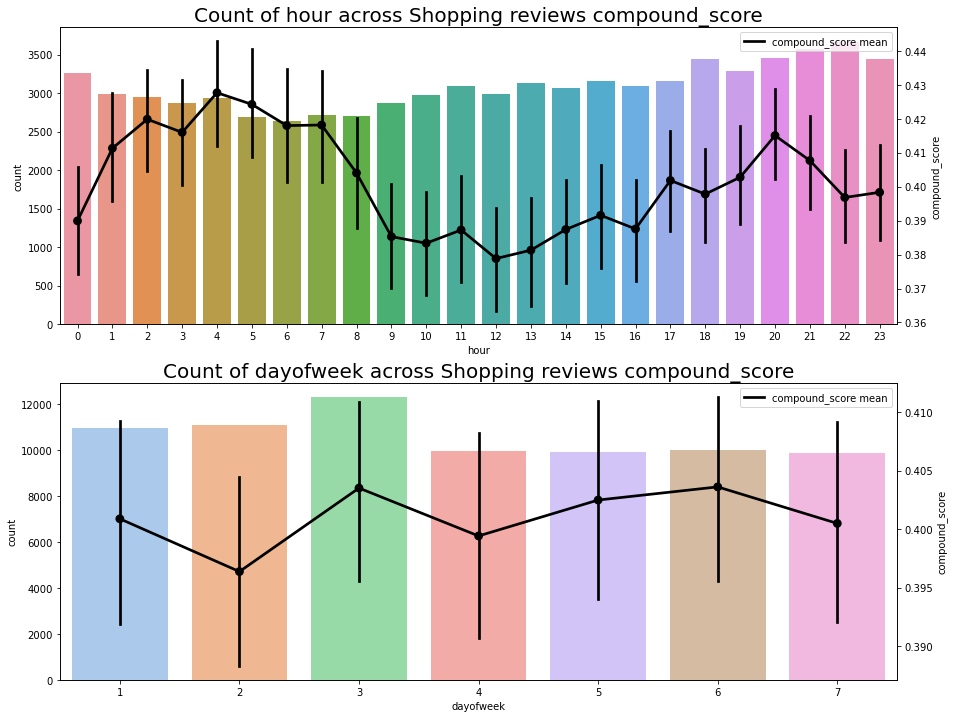

In [14]:
plot_countplots_time(df, ['hour', 'dayofweek'], 'compound_score')

## Distribution of Wordlen, Wordcount

Average text length of good reviews: 51
Average text length of bad reviews: 161
Average word count of good reviews: 9
Average word count of bad reviews: 30


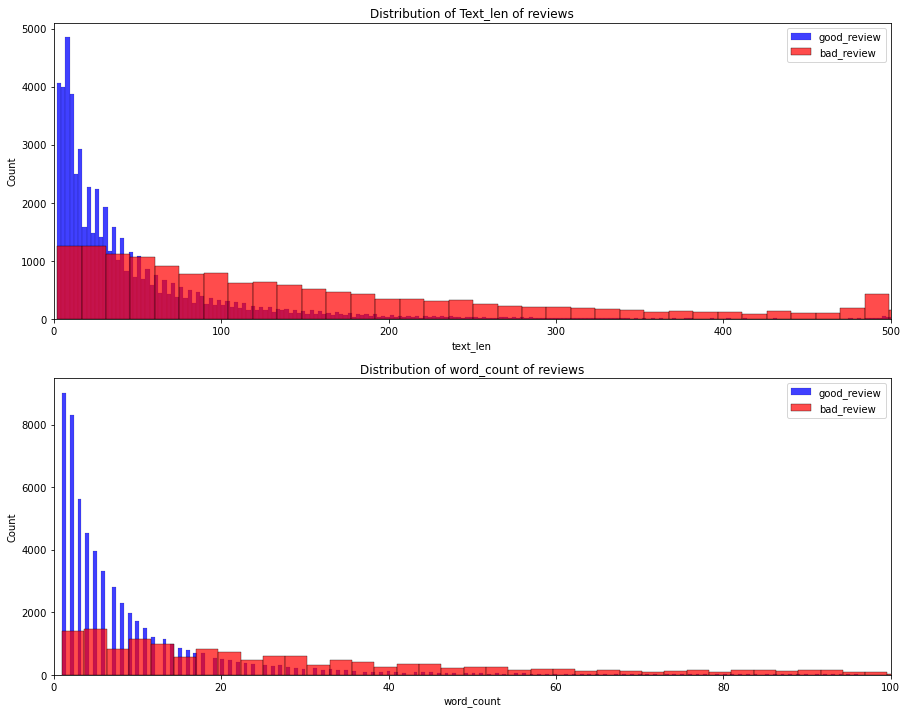

In [15]:
print(f'Average text length of good reviews: {round(df.text_len[df.rating > 3].mean())}')
print(f'Average text length of bad reviews: {round(df.text_len[df.rating <= 3].mean())}')
print(f'Average word count of good reviews: {round(df.word_count[df.rating > 3].mean())}')
print(f'Average word count of bad reviews: {round(df.word_count[df.rating <= 3].mean())}')

fig, ax = plt.subplots(2,1, figsize = (15, 12))
plt.subplots_adjust(hspace = 0.2)
ax[0].set_title('Distribution of Text_len of reviews')
sns.histplot(data = df[df['rating'] > 3], x = 'text_len', color = 'b', ax = ax[0], label = 'good_review')
sns.histplot(data = df[df['rating'] <= 3], x = 'text_len', alpha = 0.7, ax = ax[0], color = 'r', label = 'bad_review')
ax[0].set_xlim([0,500])
ax[0].legend()

ax[1].set_title('Distribution of word_count of reviews')
sns.histplot(data = df[df['rating'] > 3], x = 'word_count', color = 'b', ax = ax[1], label = 'good_review')
sns.histplot(data = df[df['rating'] <= 3], x = 'word_count', alpha = 0.7, ax = ax[1], color = 'r', label = 'bad_review')
ax[1].set_xlim([0,100])
ax[1].legend();

## Distribution of Adj, Noun, Verb and Emoji

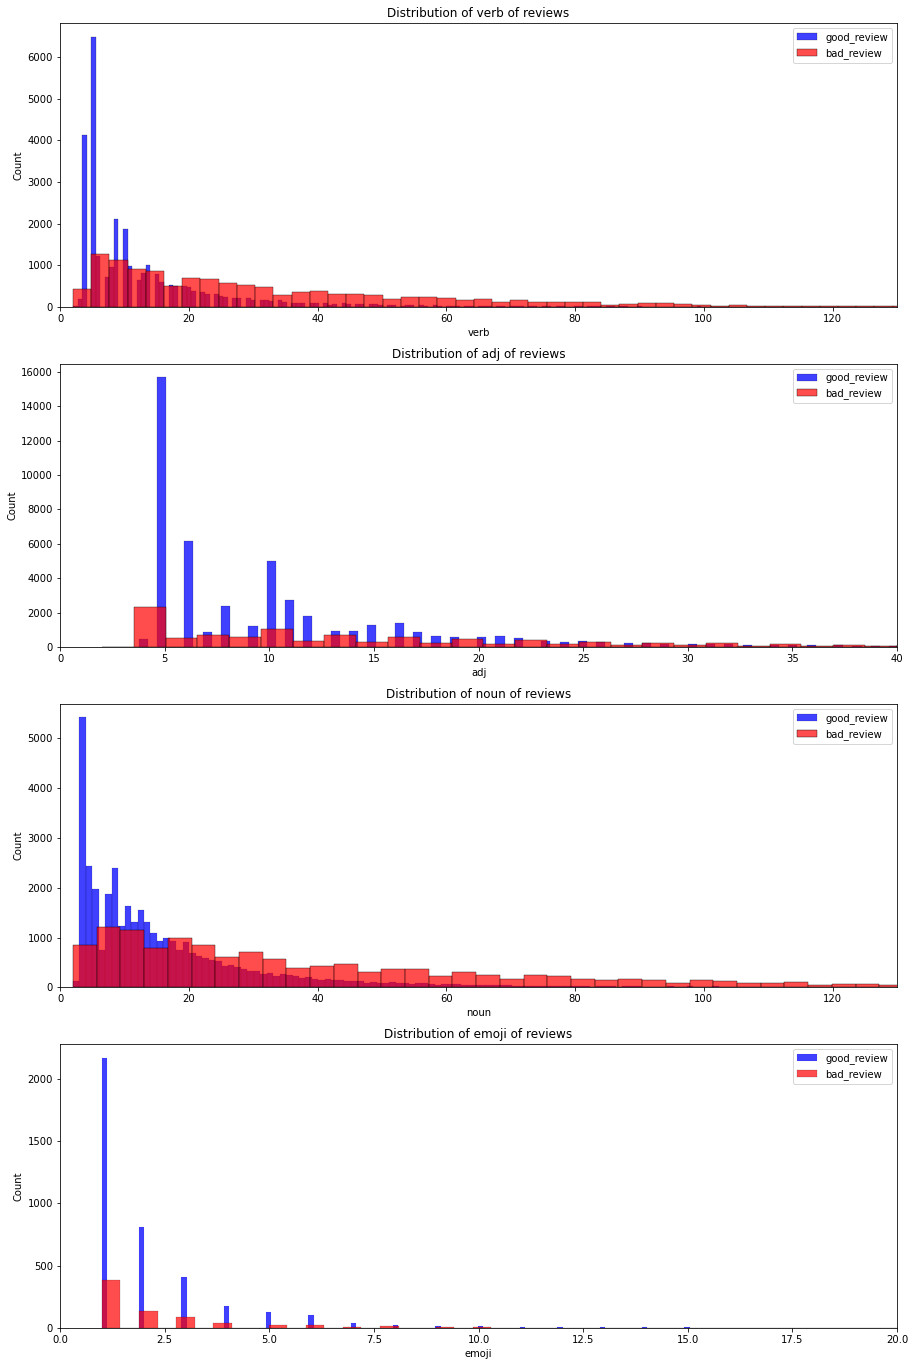

In [16]:
fig, ax = plt.subplots(4,1, figsize = (15, 24))
plt.subplots_adjust(hspace = 0.2)

ax[0].set_title('Distribution of verb of reviews')
sns.histplot(data = df[df['rating'] > 3], x = round(df[df['rating'] > 3]['verb'].str.len()), color = 'b', ax = ax[0], label = 'good_review')
sns.histplot(data = df[df['rating'] <= 3], x = round(df[df['rating'] <= 3]['verb'].str.len()), alpha = 0.7, ax = ax[0], color = 'r', label = 'bad_review')
ax[0].set_xlim([0,130])
ax[0].legend()

ax[1].set_title('Distribution of adj of reviews')
sns.histplot(data = df[df['rating'] > 3], x = round(df[df['rating'] > 3]['adj'].str.len()), color = 'b', ax = ax[1], label = 'good_review')
sns.histplot(data = df[df['rating'] <= 3], x = round(df[df['rating'] <= 3]['adj'].str.len()), alpha = 0.7, ax = ax[1], color = 'r', label = 'bad_review')
ax[1].set_xlim([0,40])
ax[1].legend();


ax[2].set_title('Distribution of noun of reviews')
sns.histplot(data = df[df['rating'] > 3], x = round(df[df['rating'] > 3]['noun'].str.len()), color = 'b', ax = ax[2], label = 'good_review')
sns.histplot(data = df[df['rating'] <= 3], x = round(df[df['rating'] <= 3]['noun'].str.len()), alpha = 0.7, ax = ax[2], color = 'r', label = 'bad_review')
ax[2].set_xlim([0,130])
ax[2].legend()

ax[3].set_title('Distribution of emoji of reviews')
sns.histplot(data = df[df['rating'] > 3], x = round(df[df['rating'] > 3]['emoji'].str.len()), color = 'b', ax = ax[3], label = 'good_review')
sns.histplot(data = df[df['rating'] <= 3], x = round(df[df['rating'] <= 3]['emoji'].str.len()), alpha = 0.7, ax = ax[3], color = 'r', label = 'bad_review')
ax[3].set_xlim([0,20])
ax[3].legend();

## Boxplot of Rating across apps

In [18]:
parameter = 'rating'
y0 = df.loc[df['app'] == 'shoppee'][parameter]
y1 = df.loc[df['app'] == 'carousell'][parameter]
y2 = df.loc[df['app'] == 'lazada'][parameter]
y3 = df.loc[df['app'] == 'aliexpress'][parameter]
y4 = df.loc[df['app'] == 'ebay'][parameter]
y5 = df.loc[df['app'] == 'amazon'][parameter]
y6 = df.loc[df['app'] == 'asos'][parameter]
y7 = df.loc[df['app'] == 'wish'][parameter]

trace0 = go.Box(y=y0,name = 'shoppee',marker = dict(color = 'rgb(214, 12, 140)',))

trace1 = go.Box(y=y1,name = 'carousell',marker = dict(color = 'rgb(0, 128, 128)',))

trace2 = go.Box(y=y2,name = 'lazada',marker = dict(color = 'rgb(10, 140, 208)',))

trace3 = go.Box(y=y3,name = 'aliexpress',marker = dict(color = 'rgb(12, 102, 14)',))

trace4 = go.Box(y=y4,name = 'ebay',marker = dict(color = 'rgb(10, 0, 100)',))

trace5 = go.Box(y=y5,name = 'amazon', marker = dict(color = 'rgb(100, 0, 10)',))

trace6 = go.Box(y=y6,name = 'asos',marker = dict(color = 'rgb(255, 212, 59)',))

trace7 = go.Box(y=y7,name = 'wish',marker = dict(color = 'rgb(100, 100, 100)',)
               )
data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]

layout = go.Layout(title = "Sentiment rating Boxplot of app")

fig = go.Figure(data=data,layout=layout)
fig.update_layout(autosize=False,width=1000,height=500,
                  margin=dict(l=50,r=50,b=100,t=100,pad=4),paper_bgcolor="white")

iplot(fig, filename = "Sentiment rating Boxplot of app", image_width=600, image_height=400,)

## Boxplot of Rating across apps

In [53]:
parameter = 'compound_score'
y0 = df.loc[df['app'] == 'shoppee'][parameter]
y1 = df.loc[df['app'] == 'carousell'][parameter]
y2 = df.loc[df['app'] == 'lazada'][parameter]
y3 = df.loc[df['app'] == 'aliexpress'][parameter]
y4 = df.loc[df['app'] == 'ebay'][parameter]
y5 = df.loc[df['app'] == 'amazon'][parameter]
y6 = df.loc[df['app'] == 'asos'][parameter]
y7 = df.loc[df['app'] == 'wish'][parameter]

trace0 = go.Box(y=y0,name = 'shoppee',marker = dict(color = 'rgb(214, 12, 140)',))

trace1 = go.Box(y=y1,name = 'carousell',marker = dict(color = 'rgb(0, 128, 128)',))

trace2 = go.Box(y=y2,name = 'lazada',marker = dict(color = 'rgb(10, 140, 208)',))

trace3 = go.Box(y=y3,name = 'aliexpress',marker = dict(color = 'rgb(12, 102, 14)',))

trace4 = go.Box(y=y4,name = 'ebay',marker = dict(color = 'rgb(10, 0, 100)',))

trace5 = go.Box(y=y5,name = 'amazon', marker = dict(color = 'rgb(100, 0, 10)',))

trace6 = go.Box(y=y6,name = 'asos',marker = dict(color = 'rgb(255, 212, 59)',))

trace7 = go.Box(y=y7,name = 'wish',marker = dict(color = 'rgb(100, 100, 100)',)
               )
data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]

layout = go.Layout(title = "Sentiment compound_score Boxplot of app")

fig = go.Figure(data=data,layout=layout)
fig.update_layout(autosize=False,width=1000,height=500,
                  margin=dict(l=50,r=50,b=100,t=100,pad=4),paper_bgcolor="white")

iplot(fig, filename = "Sentiment compound_score Boxplot of app", image_width=600, image_height=400,)

## Distribution of Keywords

In [19]:
def get_top_n_words(df, corpus, n=None):
    
    fig, ax = plt.subplots(1,len(corpus), figsize = (8*len(corpus), 6))
    plt.subplots_adjust(wspace = 0.4)
    
    for i in range(len(corpus)):
        vec = CountVectorizer().fit(df[corpus[i]])
        bag_of_words = vec.transform(df[corpus[i]])
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        
        count_df = pd.DataFrame(words_freq[:n], columns = ['review' , 'count'])
        ax[i].set_title(f'Top {n} keywords in {corpus[i]}',fontdict = {'fontsize': 20})
        sns.barplot(data = count_df, x = 'count', y = 'review', ax= ax[i])
        sns.despine(left = True, bottom = False, ax = ax[i]);

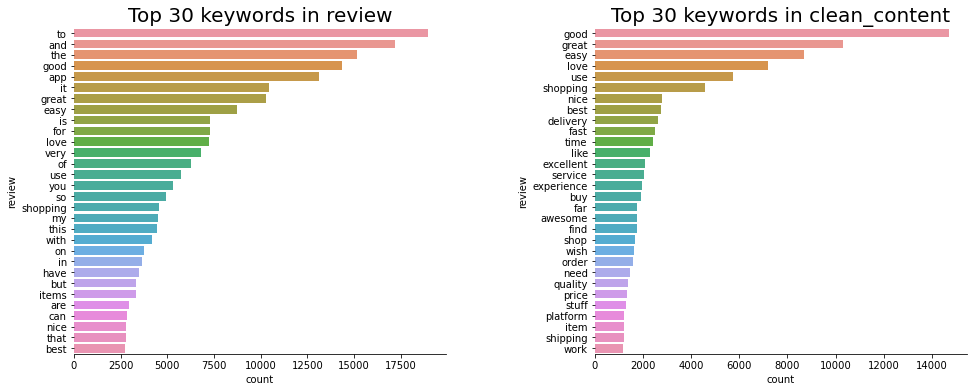

In [20]:
get_top_n_words(df[df['rating'] > 3], ['review', 'clean_content'], 30)

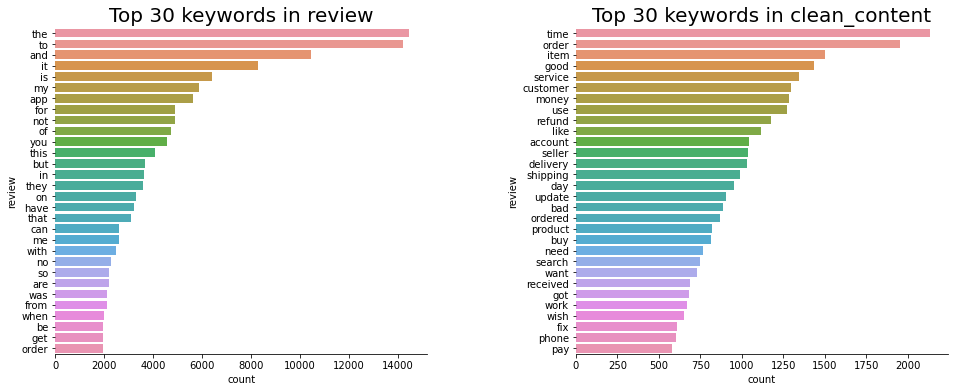

In [21]:
get_top_n_words(df[df['rating'] <= 3], ['review', 'clean_content'], 30)

## Distribution of Bigram Keywords

In [22]:
def get_top_n_bigrams(df, corpus, n=None):
    
    fig, ax = plt.subplots(1,len(corpus), figsize = (8*len(corpus), 6))
    plt.subplots_adjust(wspace = 0.4)
    
    for i in range(len(corpus)):
        vec = CountVectorizer(ngram_range=(2, 2)).fit(df[corpus[i]])
        bag_of_words = vec.transform(df[corpus[i]])
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        
        count_df = pd.DataFrame(words_freq[:n], columns = ['review' , 'count'])
        ax[i].set_title(f'Top {n} Bigrams keywords in {corpus[i]}',fontdict = {'fontsize': 20})
        sns.barplot(data = count_df, x = 'count', y = 'review', ax= ax[i])
        sns.despine(left = True, bottom = False, ax = ax[i]);

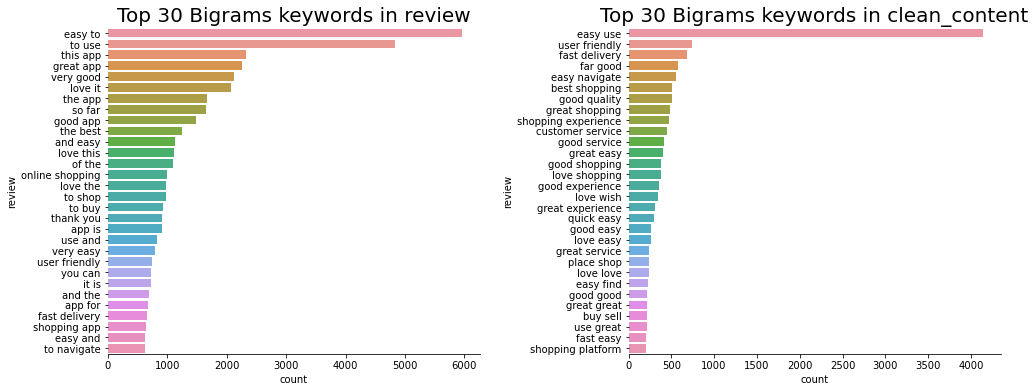

In [23]:
get_top_n_bigrams(df[df['rating'] > 3], ['review', 'clean_content'], 30)

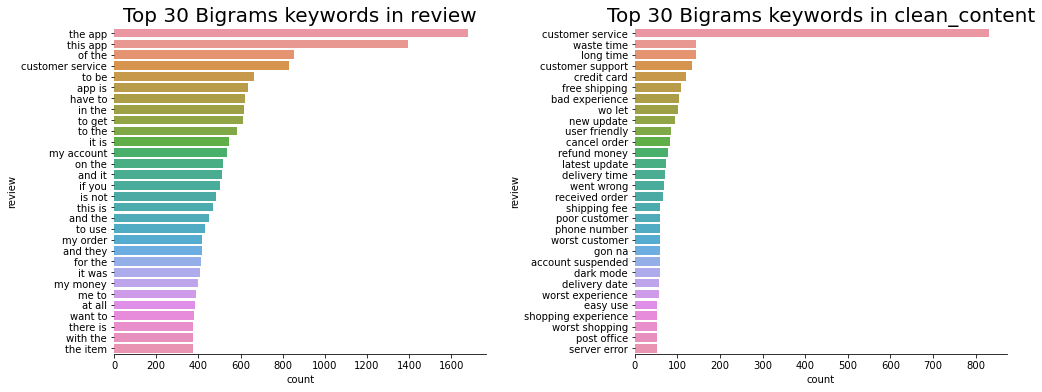

In [24]:
get_top_n_bigrams(df[df['rating'] <= 3], ['review', 'clean_content'], 30)

## Distribution of Trigram Keywords

In [25]:
def get_top_n_trigrams(df, corpus, n=None):
    
    fig, ax = plt.subplots(1,len(corpus), figsize = (8*len(corpus), 6))
    plt.subplots_adjust(wspace = 0.4)
    
    for i in range(len(corpus)):
        vec = CountVectorizer(ngram_range=(3, 3)).fit(df[corpus[i]])
        bag_of_words = vec.transform(df[corpus[i]])
        sum_words = bag_of_words.sum(axis=0)
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        
        count_df = pd.DataFrame(words_freq[:n], columns = ['review' , 'count'])
        ax[i].set_title(f'Top {n} Trigram keywords in {corpus[i]}',fontdict = {'fontsize': 20})
        sns.barplot(data = count_df, x = 'count', y = 'review', ax= ax[i])
        sns.despine(left = True, bottom = False, ax = ax[i]);

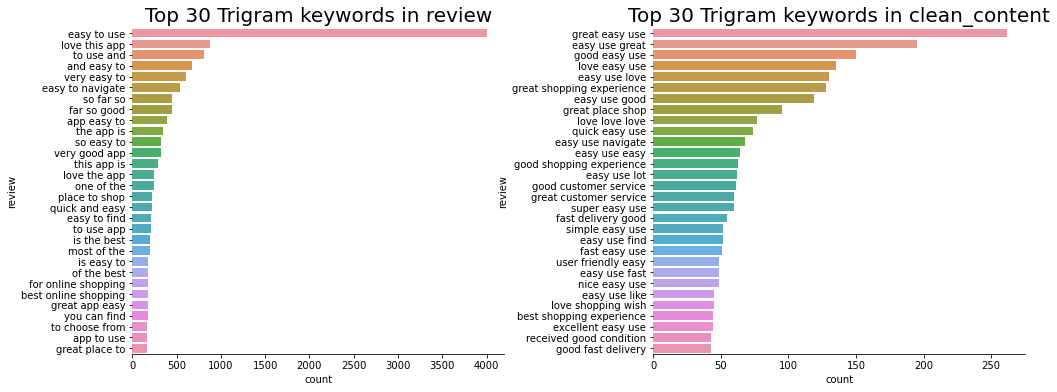

In [26]:
get_top_n_trigrams(df[df['rating'] > 3], ['review', 'clean_content'], 30)

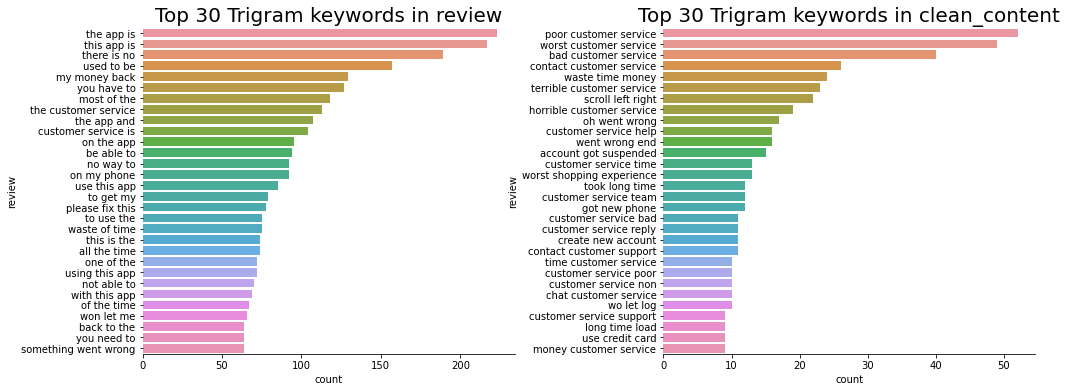

In [27]:
get_top_n_trigrams(df[df['rating'] <= 3], ['review', 'clean_content'], 30)

## Extra: Interactive plot of ratings

In [49]:
month = widgets.IntSlider(value=1.0,min=1.0,max=9.0,step=1.0,
                          description='Month:',continuous_update=False)

use_date = widgets.Checkbox(description='Date: ',value=True,)

container = widgets.HBox(children=[use_date, month])

store = widgets.Dropdown(description='Store:   ',value='apple',
                         options=df['store'].unique().tolist())

app = widgets.Dropdown(options=list(df['app'].unique()),
                       value='shoppee',description='App:',)


trace1 = go.Histogram(x=df[df['rating'] > 3]['rating'], opacity=0.75, name='Good reviews')
trace2 = go.Histogram(x=df[df['rating'] <= 3]['rating'], opacity=0.75, name='Bad reviews')
g = go.FigureWidget(data=[trace1, trace2],
                    layout=go.Layout(
                        title=dict(
                            text='Apps Ratings'
                        ),
                        barmode='overlay'
                    ))
g.update_layout(autosize=False,width=1000,height=500,
                margin=dict(l=50,r=50, b=100,t=100,pad=4),
                paper_bgcolor="white",);

In [50]:
def validate():
    if app.value in df['app'].unique() and store.value in df['store'].unique():
        return True
    else:
        return False


def response(change):
    if validate():
        if use_date.value:
            filter_list = [i and j and k for i, j, k in
                           zip(df['month'] == month.value, df['store'] == store.value,
                               df['app'] == app.value)]
            temp_df = df[filter_list]

        else:
            filter_list = [i and j for i, j in
                           zip(df['store'] == 'apple', df['app'] == app.value)]
            temp_df = df[filter_list]
        x1 = temp_df[temp_df['rating'] > 3]['rating']
        x2 = temp_df[temp_df['rating'] <= 3]['rating']
        with g.batch_update():
            g.data[0].x = x1
            g.data[1].x = x2
            g.layout.barmode = 'overlay'
            g.layout.xaxis.title = 'Ratings'
            g.layout.yaxis.title = 'Number of Reviews'


app.observe(response, names="value")
store.observe(response, names="value")
month.observe(response, names="value")
use_date.observe(response, names="value")

In [51]:
container2 = widgets.HBox([app, store])
display(widgets.VBox([container,container2,g]))

# Topic Modeling for above average ratings (4, 5 ratings )

## Converting to list

In [20]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df[df['rating'] > 3].clean_content.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['came', 'early', 'good']]


## LDA Modelling

In [21]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_words]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=42,
                                           chunksize = 4000,
                                           passes = 10,
                                           alpha = 'asymmetric')

pprint(lda_model.print_topics())

[(0,
  '0.158*"good" + 0.110*"easy" + 0.071*"use" + 0.034*"best" + 0.031*"shopping" '
  '+ 0.023*"excellent" + 0.022*"shop" + 0.021*"quality" + 0.017*"amazing" + '
  '0.016*"price"'),
 (1,
  '0.189*"love" + 0.049*"wish" + 0.047*"fast" + 0.044*"nice" + 0.044*"service" '
  '+ 0.039*"delivery" + 0.023*"quick" + 0.022*"customer" + 0.021*"happy" + '
  '0.018*"shopping"'),
 (2,
  '0.324*"great" + 0.055*"awesome" + 0.039*"like" + 0.033*"shopping" + '
  '0.026*"experience" + 0.022*"fun" + 0.015*"enjoy" + 0.015*"clothing" + '
  '0.013*"site" + 0.012*"lot"'),
 (3,
  '0.066*"buy" + 0.066*"find" + 0.053*"need" + 0.031*"want" + 0.021*"stuff" + '
  '0.019*"sell" + 0.019*"perfect" + 0.018*"like" + 0.017*"fantastic" + '
  '0.015*"look"'),
 (4,
  '0.058*"time" + 0.039*"order" + 0.038*"far" + 0.030*"shipping" + '
  '0.023*"item" + 0.020*"wish" + 0.019*"ordered" + 0.017*"size" + '
  '0.016*"delivery" + 0.016*"work"')]


## Categorizing sorted data

In [22]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num),
                                                                  round(prop_topic,4),
                                                                  topic_keywords]), 
                                                       ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic['Document_No'] = df[df['rating'] > 3].index
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.5832,"good, easy, use, best, shopping, excellent, sh...","[came, early, good]"
1,1,0.0,0.7773,"good, easy, use, best, shopping, excellent, sh...","[good, convenient]"
2,2,0.0,0.5624,"good, easy, use, best, shopping, excellent, sh...","[purchase, experience, happy]"
3,3,0.0,0.8330,"good, easy, use, best, shopping, excellent, sh...","[lot, good, deal]"
4,4,1.0,0.7433,"love, wish, fast, nice, service, delivery, qui...","[delivery, fast]"
5,5,4.0,0.5596,"time, order, far, shipping, item, wish, ordere...",[honest]
6,6,4.0,0.6518,"time, order, far, shipping, item, wish, ordere...","[new, user, set, payment, getting, time, choos..."
7,7,2.0,0.7208,"great, awesome, like, shopping, experience, fu...","[fun, experience]"
8,8,0.0,0.4443,"good, easy, use, best, shopping, excellent, sh...","[good, service]"
9,9,0.0,0.5832,"good, easy, use, best, shopping, excellent, sh...","[great, good, price]"


In [23]:
df_dominant_topic.tail()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
59102,74153,4.0,0.3744,"time, order, far, shipping, item, wish, ordere...","[happy, purchase, express, experience, shoppin..."
59103,74155,1.0,0.6239,"love, wish, fast, nice, service, delivery, qui...","[delivery, fast, item, nicely]"
59104,74156,3.0,0.5921,"buy, find, need, want, stuff, sell, perfect, l...","[convenient, need, log, search, aliexpress, com]"
59105,74158,2.0,0.7939,"great, awesome, like, shopping, experience, fu...","[tested, accurately, awesome]"
59106,74159,0.0,0.6664,"good, easy, use, best, shopping, excellent, sh...",[good]


## WordCloud visualization

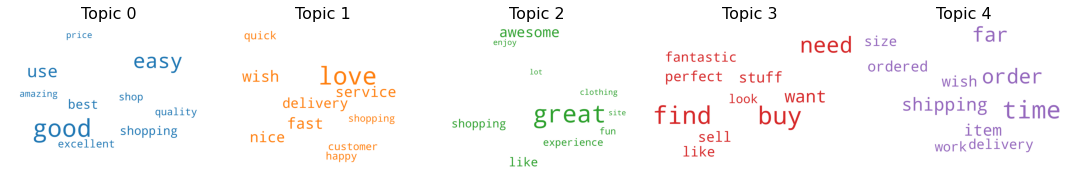

In [24]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(ncols=5, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Sentence Topic Coloring 

In [25]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.258506 -0.195243       1        1  34.553490
1      0.261060 -0.170739       2        1  19.830809
4      0.228057  0.037361       3        1  18.063931
2     -0.181574 -0.012796       4        1  14.470421
3     -0.049037  0.341417       5        1  13.081351, topic_info=         Term          Freq         Total Category  logprob  loglift
23      great   9999.000000   9999.000000  Default  30.0000  30.0000
31       love   7992.000000   7992.000000  Default  29.0000  29.0000
2        good  11629.000000  11629.000000  Default  28.0000  28.0000
34       easy   8065.000000   8065.000000  Default  27.0000  27.0000
36        use   5265.000000   5265.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
14       item    324.854980   1207.162231   Topic5  -4.4524   0.7213
15        new    216.445892    455.271210   Topic5  -4.8585   1.2904
185     place    264.882935    849.518372   Topic5  -4.6565   0.8686
24      price    216.234787   1363.289062   Topic5  -4.8594   0.1927
102  platform    189.522217   1101.204712   Topic5  -4.9913   0.2743

[246 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
93        5  0.996438        able
924       1  0.998060  absolutely
325       5  0.998263      access
243       3  0.996894     account
299       2  0.996073         add
...     ...       ...         ...
345       3  0.649513        work
345       4  0.349166        work
191       1  0.002809       worth
191       2  0.997203       worth
271       2  0.996070       wrong

[265 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 5, 3, 4])

# Topic Modeling for below average ratings (1 - 3 ratings )

## Converting to List

In [26]:
data = df[df['rating'] <= 3].clean_content.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['stupid', 'bubble', 'game', 'impossible', 'bubble', 'colour', 'shoot', 'stupid']]


## LDA Modelling

In [27]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_words]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=42,
                                           chunksize = 1000,
                                           passes = 15,
                                           alpha = 'asymmetric')

pprint(lda_model.print_topics())

[(0,
  '0.031*"service" + 0.027*"customer" + 0.018*"account" + 0.014*"help" + '
  '0.012*"use" + 0.011*"time" + 0.011*"bad" + 0.009*"order" + 0.009*"support" '
  '+ 0.009*"problem"'),
 (1,
  '0.025*"seller" + 0.022*"item" + 0.019*"shipping" + 0.019*"product" + '
  '0.018*"like" + 0.017*"wish" + 0.015*"good" + 0.015*"buy" + 0.010*"money" + '
  '0.010*"way"'),
 (2,
  '0.056*"order" + 0.051*"delivery" + 0.040*"ordered" + 0.039*"time" + '
  '0.038*"refund" + 0.035*"good" + 0.030*"day" + 0.030*"received" + '
  '0.027*"long" + 0.026*"receive"'),
 (3,
  '0.041*"difficult" + 0.025*"buyer" + 0.023*"seller" + 0.020*"refuse" + '
  '0.014*"de" + 0.014*"beware" + 0.013*"march" + 0.009*"accepted" + '
  '0.009*"clothing" + 0.009*"baby"'),
 (4,
  '0.041*"update" + 0.035*"search" + 0.027*"fix" + 0.023*"page" + 0.020*"work" '
  '+ 0.019*"load" + 0.015*"screen" + 0.015*"annoying" + 0.014*"new" + '
  '0.014*"list"')]


## Categorizing sorted Data

In [28]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic['Document_No'] = df[df['rating'] <= 3].index
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,11,0.0,0.7887,"service, customer, account, help, use, time, b...","[stupid, bubble, game, impossible, bubble, col..."
1,40,4.0,0.6220,"update, search, fix, page, work, load, screen,...","[recent, update, shoppe, bubble, game, unplaya..."
2,68,0.0,0.8500,"service, customer, account, help, use, time, b...","[came, contact, live, chat, rep, purposely, wa..."
3,121,4.0,0.5255,"update, search, fix, page, work, load, screen,...","[aware, beat, certain, voucher, able, use, fou..."
4,138,1.0,0.5147,"seller, item, shipping, product, like, wish, g...","[account, received, defective, item, got, hone..."
5,139,0.0,0.5407,"service, customer, account, help, use, time, b...","[team, hopeless, usual, sending, life, bubble,..."
6,150,0.0,0.7648,"service, customer, account, help, use, time, b...","[hi, hard, shoot, bubble, play, bubble, mainte..."
7,173,0.0,0.5487,"service, customer, account, help, use, time, b...","[force, close, time, hope, improvement, update]"
8,176,0.0,0.7769,"service, customer, account, help, use, time, b...","[dumb, login]"
9,208,1.0,0.7467,"seller, item, shipping, product, like, wish, g...","[poor, customer, service, policy, mislead, sen..."


In [29]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9835,"service, customer, account, help, use, time, bad, order, support, problem","[terrible, deserve, star, totally, user, friendly, link, social, medium, link, properly, correct..."
1,1.0,0.9737,"seller, item, shipping, product, like, wish, good, buy, money, way","[good, platform, thing, wrong, parcel, store, want, need, post, parcel, nearest, drop, point, mi..."
2,2.0,0.9403,"order, delivery, ordered, time, refund, good, day, received, long, receive","[refund, process, long, day, day, paying, process, fast, refund, process, taking, long, day]"
3,3.0,0.9768,"difficult, buyer, seller, refuse, de, beware, march, accepted, clothing, baby","[de, dinero, han, de, responder, con, el, de, ya, mi, el, de, el, de, lo, ya, para, lo, de, mal,..."
4,4.0,0.9494,"update, search, fix, page, work, load, screen, annoying, new, list","[excellent, thing, bug, select, shop, category, page, thing, install, work, view, category, page..."


## WordCloud Visualization

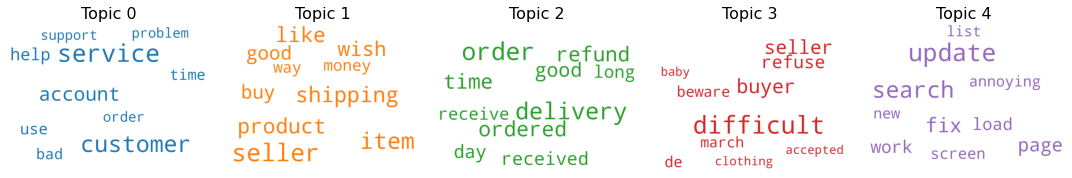

In [30]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(ncols=5, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [31]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.134038 -0.142979       1        1  36.465626
1      0.118693  0.003936       2        1  28.689936
2      0.201109  0.224741       3        1  16.373756
4     -0.121730 -0.261247       4        1  13.162626
3     -0.332109  0.175549       5        1   5.308058, topic_info=            Term         Freq        Total Category  logprob  loglift
281        order  1782.000000  1782.000000  Default  30.0000  30.0000
200     delivery  1165.000000  1165.000000  Default  29.0000  29.0000
563      ordered   933.000000   933.000000  Default  28.0000  28.0000
258       seller  1202.000000  1202.000000  Default  27.0000  27.0000
44       service  1574.000000  1574.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
2516       party    35.082256    35.831570   Topic5  -5.3605   2.9148
118       beware   100.954117   134.170532   Topic5  -4.3035   2.6515
313        buyer   185.803131   412.663818   Topic5  -3.6935   2.1380
687   protection    60.943672    97.545776   Topic5  -4.8082   2.4656
258       seller   174.664078  1202.748169   Topic5  -3.7553   1.0064

[270 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
1286      5  0.983832       accepted
72        1  0.999514        account
769       1  0.997700            add
144       1  0.993465        address
2627      5  0.991536  administrator
...     ...       ...            ...
158       2  0.088449          worst
158       3  0.414104          worst
263       1  0.712336          wrong
263       2  0.286512          wrong
52        5  0.979083            yes

[320 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 5, 4])